# Q3_letter_recognition

In [2]:
# libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from functools import partial
import pylab
import numpy as np
import numpy.linalg as npla
from sklearn.metrics import matthews_corrcoef
# dataset
letters = pd.read_csv("letter-recognition.csv")

In [3]:
# about the dataset

# dimensions
print("Dimensions: ", letters.shape, "\n")

# data types
print(letters.info())

# head
letters.head()

Dimensions:  (20000, 17) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  20000 non-null  object
 1   xbox    20000 non-null  int64 
 2   ybox    20000 non-null  int64 
 3   width   20000 non-null  int64 
 4   height  20000 non-null  int64 
 5   onpix   20000 non-null  int64 
 6   xbar    20000 non-null  int64 
 7   ybar    20000 non-null  int64 
 8   x2bar   20000 non-null  int64 
 9   y2bar   20000 non-null  int64 
 10  xybar   20000 non-null  int64 
 11  x2ybar  20000 non-null  int64 
 12  xy2bar  20000 non-null  int64 
 13  xedge   20000 non-null  int64 
 14  xedgey  20000 non-null  int64 
 15  yedge   20000 non-null  int64 
 16  yedgex  20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB
None


,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [4]:
letter_means = letters.groupby('letter').mean()
letter_means.head()

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
letter,,,,,,,,,,,,,,,,
A,3.337136,6.975919,5.128010,5.178707,2.991128,8.851711,3.631179,2.755387,2.043093,7.802281,2.338403,8.465146,2.771863,6.321926,2.875792,7.468948
B,3.985640,6.962141,5.088773,5.169713,4.596606,7.671018,7.062663,5.366841,5.571802,7.954308,5.506527,6.652742,3.117493,7.919060,6.612272,9.100522
C,4.031250,7.063859,4.701087,5.296196,2.775815,5.437500,7.627717,5.927989,7.177989,8.773098,7.494565,11.947011,1.991848,8.876359,4.080163,8.555707
D,4.023602,7.244720,5.170186,5.288199,4.026087,7.539130,6.806211,5.921739,6.508075,8.166460,5.111801,5.750311,3.365217,7.813665,3.971429,7.628571
E,3.727865,6.944010,4.756510,5.201823,3.679688,5.966146,7.352865,4.223958,7.585938,8.507812,6.242188,10.341146,2.127604,8.298177,6.022135,8.506510


## Pre processing data



In [5]:
# average feature values
round(letters.drop('letter', axis=1).mean(), 2)
# splitting into X and y

X = letters.drop("letter", axis = 1)
y = letters['letter']
# scaling the features
X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 101)

In [6]:
print(y_train)

10593    H
18903    N
6491     X
17136    V
19651    Z
        ..
5695     K
8006     P
17745    P
17931    U
13151    M
Name: letter, Length: 14000, dtype: object


## SVM with different kernels


In [7]:
import random
print(type(X_train))
print((y_train.to_numpy()))

<class 'numpy.ndarray'>
['H' 'N' 'X' ... 'P' 'U' 'M']


In [8]:
def markov_samp(X_train, Y_train, k = 5, q = 1.2):

    # Init_sampl = np.concatenate((X_train, np.array()), axis = 0)
    Init_sampl = np.concatenate((np.vstack(X_train), np.vstack(Y_train.to_numpy())), axis = 1)
    Dtr = random.sample(list(Init_sampl), 2000)

    m = len(Dtr)
    print("M : " , m)
    # mplus =np.count_nonzero(np.array(Dtr[16]) == 'A')
    # mplus = Dtr[16].count('A')
    mneg = 0
    mplus = 0

    index = np.random.choice(len(Dtr), 1, replace=False)  
    Dtra = np.array(Dtr)
    print(type(Dtra))
    zt = Dtra[index][0]

    print("zt : ", zt)
    if m%2 == 0:
        if zt[16] == 'A':
            mplus += 1;
        else:
            mneg += 1
    samp = []

    Pd = 0
    Pdd = 0
    print(zt)
    while(mplus + mneg < m ):
        zstar = Dtra[np.random.choice(len(Dtr), 1, replace=False)][0]
        P = 1
        # print(zt)
        yt = zt[16]
        zt = zstar
        if P == 1:
            if zt[16] == yt:
                samp.append(zstar) #Pdash = e−y∗f0 /e−ytf0
            else:
                samp.append(zstar) #P

        if len(samp) == k:
            Pdd = q*P
            samp.append(zstar) #Pdd
            
        ztp1 = zstar
        if yt == 'A':
            mplus += 1
        else:
            mneg += 1

        if P > 1 or Pd > 1 or Pdd > 1:
            samp.append(zstar)
    return samp


In [9]:
nsamp = np.array(markov_samp(X_train, y_train))
print(nsamp.shape)
X_train = nsamp[:, 0:16]
y_train = nsamp[:, 16]
print(X_train.shape)
print(y_train.shape)

M :  2000
<class 'numpy.ndarray'>
zt :  ['-0.012309453615842696' '-0.010743015102526938' '-0.06048578502437703'
 '-0.16470367350725917' '0.2255977441294167' '-0.4430438069275676'
 '-0.21521994542421233' '1.2487127414197388' '-0.07503895724494865'
 '-0.5152079462902271' '-0.5526406630296021' '-0.44651289982586545'
 '-0.019764349464260575' '-0.8656262048483556' '-0.26947711190847695'
 '0.12291106712560491' 'N']
['-0.012309453615842696' '-0.010743015102526938' '-0.06048578502437703'
 '-0.16470367350725917' '0.2255977441294167' '-0.4430438069275676'
 '-0.21521994542421233' '1.2487127414197388' '-0.07503895724494865'
 '-0.5152079462902271' '-0.5526406630296021' '-0.44651289982586545'
 '-0.019764349464260575' '-0.8656262048483556' '-0.26947711190847695'
 '0.12291106712560491' 'N']
(3995, 17)
(3995, 16)
(3995,)


In [10]:
# print(y_train)
Y_train = []
for i in y_train:
    # print(i)
    Y_train.append(ord(i))
# print(Y_train)

In [11]:
print(X_test.shape)

(6000, 16)


In [12]:
# linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, Y_train)

y_pred = model_linear.predict(X_test)

Y_test = []
for i in y_test:
    Y_test.append(ord(i))
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=Y_test, y_pred=y_pred), "\n")
print("MCC:",  matthews_corrcoef(y_true=Y_test, y_pred=y_pred), "\n")
# cm
print(metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred))



accuracy: 0.7808333333333334 

MCC: 0.7722213294123542 

[[192   0   0   1   0   0   0   0   0   1   0   1   0   1   1   0   1   1
    0   0   1   0   0   0   3   6]
 [  0 163   0   5   1   1   1  11   1   0   0   0   0   0   1   0   2  14
   17   0   0   1   0   0   0   0]
 [  3   0 175   1  10   1  22   1   0   0   2   0   0   0   4   0   0   0
    0   4   5   0   0   1   1   0]
 [  0  17   0 211   0   2   0   6   1   0   2   0   0   2   4   0   0   1
    0   1   1   0   0   0   0   0]
 [  0   7   6   0 185   0  14   1   0   0   3   5   0   0   0   0   1   0
    1   2   0   0   0   3   0   6]
 [  0   2   1   1   4 174   2   1   1   2   0   0   0   3   0   4   0   0
    4   9   0   0   0   0  17   0]
 [  0   1  17   5   6   1 150   0   0   1   3   4   5   0   1   1  10   1
    9   0   0   2   2   0   0   0]
 [  0   6   2  19   2   6   3 136   0   1   6   1   2   6   6   1   6   5
    1   1   3   2   0   1   1   0]
 [  0   0   2   4   0   7   0   0 175   3   0   1   0   0   2   1   2  

In [13]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='rbf')

# fit
non_linear_model.fit(X_train, Y_train)

# predict
y_pred = non_linear_model.predict(X_test)
# confusion matrix and accuracy

print("MCC:",  matthews_corrcoef(y_true=Y_test, y_pred=y_pred), "\n")
# accuracy
print("accuracy:", metrics.accuracy_score(y_true=Y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred))

MCC: 0.8249762232039713 

accuracy: 0.8315 

[[191   0   0   2   0   0   0   1   0   0   0   0   1   0   0   0   0   0
    3   0   2   0   1   0   3   5]
 [  0 172   0   6   3   4   1   7   0   0   3   0   0   0   0   0   0   6
   14   0   0   1   0   1   0   0]
 [  0   0 187   0   2   1  19   0   0   0   2   0   0   0   5   0   0   0
    2   3   8   0   1   0   0   0]
 [  1  17   0 209   0   3   0   2   1   3   0   0   1   0   1   0   0   3
    2   1   1   0   0   0   0   3]
 [  0   0   5   0 199   0  13   2   0   0   1   0   0   0   0   0   0   0
    1   0   0   0   0   3   0  10]
 [  0   2   0   1   5 193   0   2   1   0   0   0   0   3   0   9   0   1
    2   6   0   0   0   0   0   0]
 [  0   2   2   9   6   1 188   0   0   0   0   0   3   0   1   0   2   0
    0   0   0   2   2   1   0   0]
 [  0  11   1  18   2   1   5 130   0   1   6   0   2  12   4   2   5   8
    1   0   3   2   0   3   0   0]
 [  0   0   1   4   0  11   0   0 175   2   0   0   0   0   0   1   0   0
   12   0

In [14]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='poly')

# fit
non_linear_model.fit(X_train, Y_train)

# predict
y_pred = non_linear_model.predict(X_test)
# confusion matrix and accuracy
print("MCC:",  matthews_corrcoef(y_true=Y_test, y_pred=y_pred), "\n")
# accuracy
print("accuracy:", metrics.accuracy_score(y_true=Y_test, y_pred=y_pred), "\n")

# cm
print(metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred))

MCC: 0.717155845892302 

accuracy: 0.7228333333333333 

[[184   0   0   4   0   0   1   1   0   0   0   1   1   0   3   0   0   1
    0   0   2   0   0   3   1   7]
 [  0 107   0   9   2   0   1   8   0   0   0   0   0   0  57   0   1  18
    3   0   0   2   0  10   0   0]
 [  1   0 162   0  10   1  22   0   0   0   0   0   0   0  22   0   0   0
    2   0   7   0   0   3   0   0]
 [  0   5   0 160   0   0   0   6   2   0   0   1   0   1  52   0   1   6
    6   0   3   0   0   5   0   0]
 [  0   1   5   0 172   0   9   0   0   0   0   0   1   0  25   0   1   1
    0   0   0   1   0  16   0   2]
 [  0   0   1   2   4 181   1   0   0   0   0   0   0   2  10   6   0   0
    4   2   0   0   1  10   1   0]
 [  0   0   2   6   1   0 145   0   0   0   0   0   3   0  54   0   4   2
    0   0   0   2   0   0   0   0]
 [  0   4   0   9   6   1   5  74   0   0   4   0   4   1  84   1   4   4
    1   0   2   0   0  12   1   0]
 [  0   0   0   4   2  11   1   0 163   0   0   0   0   0   9   1   0   

# Find best hyper parameters using cross validation

In [15]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)


hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]



model = SVC(kernel="rbf")


model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.3min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [17]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.466611,0.010629,0.189655,0.001846,1,0.01,"{'C': 1, 'gamma': 0.01}",0.752190,0.785982,0.793492,0.804756,0.802253,0.787735,0.018974,7,0.803191,0.811014,0.814768,0.823842,0.801314,0.810826,0.008170
1,0.878093,0.003965,0.208713,0.001603,1,0.001,"{'C': 1, 'gamma': 0.001}",0.461827,0.461827,0.456821,0.528160,0.479349,0.477597,0.026415,11,0.515957,0.492804,0.502503,0.510325,0.480288,0.500375,0.012706
2,1.085724,0.003590,0.208764,0.000799,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.048811,0.043805,0.053817,0.056320,0.100125,0.060576,0.020237,12,0.054130,0.055382,0.052879,0.052253,0.086984,0.060325,0.013372
3,0.277081,0.007114,0.130811,0.001217,10,0.01,"{'C': 10, 'gamma': 0.01}",0.901126,0.942428,0.902378,0.916145,0.921151,0.916646,0.015031,4,0.946809,0.950876,0.953379,0.948686,0.946183,0.949186,0.002659
4,0.461937,0.013658,0.190937,0.004247,10,0.001,"{'C': 10, 'gamma': 0.001}",0.739675,0.774718,0.769712,0.797247,0.787234,0.773717,0.019556,8,0.795056,0.797559,0.800688,0.810075,0.786295,0.797935,0.007731
5,0.874853,0.008247,0.210632,0.003133,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.460576,0.471840,0.459324,0.535670,0.481852,0.481852,0.028131,10,0.515645,0.494681,0.502503,0.514080,0.480288,0.501439,0.013083
6,0.247371,0.005770,0.095887,0.001687,100,0.01,"{'C': 100, 'gamma': 0.01}",0.974969,0.988736,0.974969,0.984981,0.977472,0.980225,0.005620,2,0.998748,0.998436,0.997810,0.998123,0.998123,0.998248,0.000319
7,0.301792,0.001806,0.139275,0.001169,100,0.001,"{'C': 100, 'gamma': 0.001}",0.868586,0.883605,0.874844,0.889862,0.894869,0.882353,0.009597,5,0.911139,0.911765,0.920213,0.918961,0.908949,0.914205,0.004510
8,0.450712,0.002193,0.185458,0.001949,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.734668,0.767209,0.772215,0.790989,0.782228,0.769462,0.019233,9,0.793179,0.790676,0.795682,0.804130,0.781289,0.792991,0.007398
9,0.249536,0.004522,0.092234,0.001972,1000,0.01,"{'C': 1000, 'gamma': 0.01}",0.977472,0.992491,0.978723,0.992491,0.982478,0.984731,0.006547,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


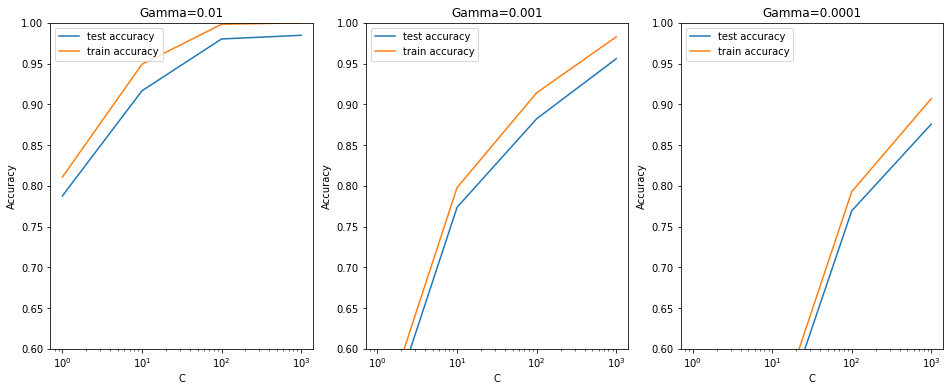

In [18]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


In [19]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))
# model with optimal hyperparameters

# model
model = SVC(C=1000, gamma=0.01, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# metrics
print("accuracy", metrics.accuracy_score(y_test, y_pred), "\n")
print(metrics.confusion_matrix(y_test, y_pred), "\n")

The best test score is 0.9847309136420526 corresponding to hyperparameters {'C': 1000, 'gamma': 0.01}
accuracy 0.8338333333333333 

[[195   1   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   1   0   1   0   2   6]
 [  0 168   0   6   0   0   1   8   0   1   0   0   0   0   0   0   1  12
   15   0   0   5   0   1   0   0]
 [  5   0 177   0   8   1  19   0   0   0   3   1   0   0   4   0   0   0
    3   3   6   0   0   0   0   0]
 [  0  17   0 208   0   3   0   9   0   1   0   0   0   1   2   0   2   2
    0   1   1   0   0   0   0   1]
 [  0   2   8   0 206   0  11   0   0   0   0   1   0   0   0   0   1   1
    0   0   0   1   0   0   0   3]
 [  0   1   0   1   2 196   2   0   2   1   0   0   0   1   0   8   0   1
    2   5   0   2   0   0   1   0]
 [  0   0   2   9   6   0 175   0   0   0   2   6   5   0   0   1   3   1
    3   1   0   2   2   1   0   0]
 [  0   8   1  16   1   2   3 135   0   2   9   1   2   9   6   2   6   6
    0   0   3   3   0   1   1  